# Lotka-Volterra toy model

The [LotkaVolterraModel](http://pints.readthedocs.io/en/latest/toy/lotka_volterra_model.html) describes the relationship between two interacting species, where one preys on the other. A good description of its history and interpretation can be found on [Wikipedia](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

The model has 2 states $x$ and $y$, where $x$ represents a population of prey, and $y$ represents a population of predators.
It is described by the ODEs:

$$ \frac{dx}{dt} = ax - bxy $$

and

$$ \frac{dy}{dt} = -cy + dxy $$

where $a, b, c$, and $d$ are the four model parameters.

In [1]:
import pints
import pints.toy

model = pints.toy.LotkaVolterraModel()

print('Outputs: ' + str(model.n_outputs()))
print('Parameters: ' + str(model.n_parameters()))

Outputs: 2
Parameters: 4


The model comes pre-packaged with lynx-hare pelt count data collected by the Hudson's
Bay Company in Canada in the early twentieth century, which is taken
from [1]. The data given here corresponds to annual observations
taken from 1900-1920 (inclusive). We now plot this data.

[1] Howard, P. (2009). Modeling basics. Lecture Notes for Math 442,
           Texas A&M University

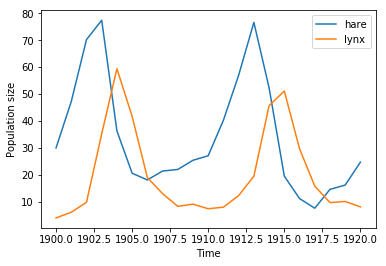

In [3]:
times = model.suggested_times() + 1900
values = model.suggested_values()

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Time')
plt.ylabel('Population size')
plt.plot(times, values)
plt.legend(['hare', 'lynx'])
plt.show()

In this set-up, the first state represents the prey, and the second the predators.
When there is no prey, the predators begin to die out, which allows the prey population to recover.

To show the cyclical nature more clearly, these two populations are often plotted against each other:

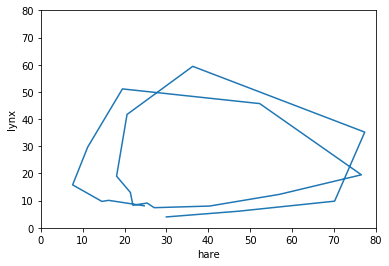

In [4]:
plt.figure()
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.xlabel('hare')
plt.ylabel('lynx')
plt.plot(values[:, 0], values[:, 1])
plt.show()

We now use PINTS to fit the Lotka-Volterra model (with fixed initial conditions $[x,y]=[30, 4]$) to the pelts data on lynxs and hares. Previous work has showed that a multiplicative noise model is more appropriate to fit these data [2]. As such, we fit the model to the log of the series.

[2] Predator-Prey Population Dynamics: the Lotka-Volterra model in Stan. Carpenter, B. https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html

In [14]:
import numpy as np

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, np.log(values))

# Create a log posterior
log_prior_theta = pints.UniformLogPrior(lower_or_boundaries=0, upper=2)
log_prior_sigma = pints.GaussianLogPrior(mean=0, sd=3)
log_prior = pints.ComposedLogPrior(log_prior_theta, log_prior_theta, log_prior_theta, log_prior_theta,
                                   log_prior_sigma, log_prior_sigma)
log_likelihood = pints.GaussianLogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [[0.43, 0.16, 0.9, 0.27, 0.28, 0.26]] * 4
mcmc = pints.MCMCController(log_posterior, 4, x0)
mcmc.set_max_iterations(4000)

print('Running')
timer = pints.Timer()
chains = mcmc.run()
t = timer.time()
print('Done!')

Running
Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0.5       0         0          0:00.1
2     12     0.333     0.667     0         0          0:00.1
3     16     0.5       0.75      0         0          0:00.2
20    84     0.476     0.571     0.238     0.333      0:00.8
40    164    0.463     0.512     0.317     0.439      0:01.5
60    244    0.393     0.475     0.344     0.459      0:02.1
80    324    0.432     0.395     0.37      0.407      0:02.8
100   404    0.436     0.396     0.366     0.366      0:03.5
120   484    0.471     0.405     0.405     0.331      0:04.2
140   564    0.461     0.411     0.426     0.362      0:04.9
160   644    0.429     0.435     0.404     0.348      0:05.6
180   724    0.441989  0.42      0.381     0.348      0:06.2
Initial phase completed.
200   804    0.43

2580  10324  0.168     0.164     0.187     0.170864   1:05.3
2600  10404  0.166     0.162     0.185     0.17       1:06.0
2620  10484  0.165     0.161     0.184     0.168      1:06.7
2640  10564  0.163953  0.159788  0.183     0.167      1:07.3
2660  10644  0.163     0.158587  0.181     0.166      1:08.0
2680  10724  0.162     0.157404  0.18      0.164      1:08.6
2700  10804  0.160311  0.156     0.178     0.163      1:09.3
2720  10884  0.159     0.15509   0.177     0.162      1:10.1
2740  10964  0.158     0.154     0.176     0.161      1:10.7
2760  11044  0.157     0.153     0.175     0.16       1:11.4
2780  11124  0.156     0.151744  0.173319  0.159      1:12.3
2800  11204  0.155     0.151     0.172     0.157      1:12.9
2820  11284  0.153     0.15      0.171     0.156      1:13.7
2840  11364  0.152     0.149     0.17      0.155227   1:14.4
2860  11444  0.151     0.148     0.168     0.154      1:15.1
2880  11524  0.150295  0.146     0.167303  0.153      1:15.8
2900  11604  0.149     0

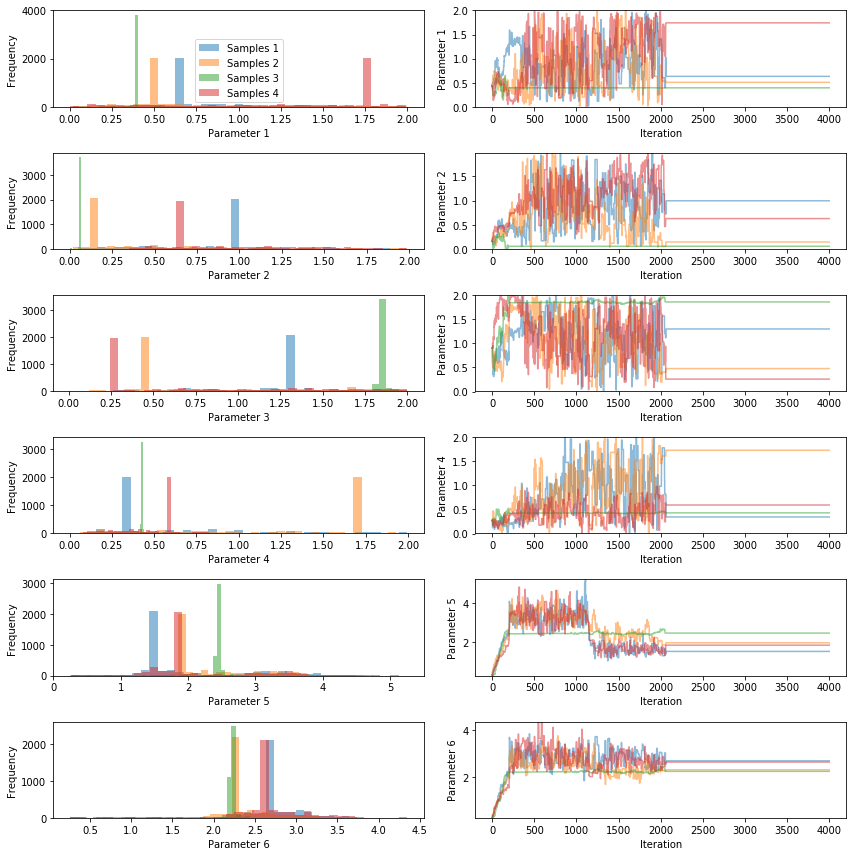

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [16]:
results = pints.MCMCSummary(chains=chains, parameter_names=["a", "b", "c", "d", "sigma_1", "sigma_2"], time=t)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
a        0.80    0.52    0.19    0.39   0.60   1.17   1.76     1.74    195.50  1.39
b        0.56    0.48    0.06    0.09   0.55   1.00   1.65     1.78    79.26   0.56
c        1.15    0.61    0.26    0.48   1.30   1.84   1.91     1.98    92.29   0.65
d        0.70    0.50    0.16    0.38   0.43   0.79   1.72     1.93    117.69  0.83
sigma_1  2.21    0.69    1.26    1.83   1.95   2.46   3.80     1.24    53.22   0.38
sigma_2  2.46    0.45    1.30    2.23   2.42   2.68   3.35     1.16    103.00  0.73


We can also compare the predictions with these values to what we found: looks like a reasonable fit.

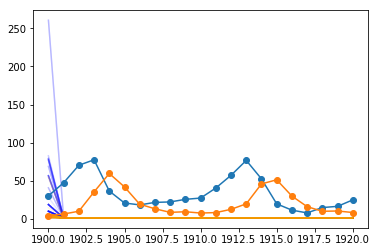

In [17]:
# Select first chain
chain1 = chains[0]

# Remove burn-in
chain1 = chain1[500:]

# Plot some predictions with these samples
num_lines = 100
hare = np.zeros((len(times), num_lines))
lynx = np.zeros((len(times), num_lines))
for i in range(num_lines):
    temp = np.exp(model.simulate(times=times, parameters=chain1[i, :4]))
    hare[:, i] = temp[:, 0]
    lynx[:, i] = temp[:, 1]
plt.plot(times, hare, color="b", alpha=0.1)
plt.plot(times, lynx, color="orange", alpha=0.1)
plt.plot(times, values, 'o-')
plt.show()

Since this is a tricky model to fit, let's use HMC to fit the same data.

In [19]:
# Run MCMC on the noisy data
x0 = [[0.43, 0.16, 0.9, 0.27, 0.28, 0.26]] * 4
mcmc = pints.MCMCController(log_posterior, 4, x0, method=pints.HamiltonianMCMC)
mcmc.set_max_iterations(200)
mcmc.set_log_interval(1)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.1, 0.01, 0.1, 0.03, 0.05, 0.05])
    sampler.set_leapfrog_steps(10)

print('Running')
timer = pints.Timer()
chains = mcmc.run()
t = timer.time()
print('Done!')

Running
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.3
1     44     0         0         0         0          0:00.4
2     84     0         0         0         0          0:00.4
3     124    0         0         0         0          0:00.4
4     164    0         0         0         0          0:00.5


/home/michael/dev/pints/pints/_boundaries.py:95: RuntimeWarning: invalid value encountered in less
  if np.any(parameters < self._lower):
/home/michael/dev/pints/pints/_boundaries.py:97: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(parameters >= self._upper):
/usr/lib64/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/michael/dev/pints/pints/_log_likelihoods.py:499: RuntimeWarning: overflow encountered in multiply
  (sigma**(-2.0) * np.sum((r.T * dy.T).T, axis=0).T).T, axis=0)
/home/michael/dev/pints/pints/_log_likelihoods.py:502: RuntimeWarning: overflow encountered in square
  dsigma = -self._nt / sigma + sigma**(-3.0) * np.sum(r**2, axis=0)


5     204    0         0         0         0          0:00.5
6     244    0         0         0         0          0:00.6
7     284    0         0         0         0          0:00.6
8     324    0         0         0         0          0:00.6
9     364    0         0         0         0          0:00.7
10    404    0         0         0         0          0:00.7
11    444    0         0         0         0          0:00.8
12    484    0         0         0         0          0:00.8
13    524    0         0         0         0          0:00.8
14    564    0         0         0         0          0:00.9
15    604    0         0         0         0          0:00.9
16    644    0         0         0         0          0:00.9
17    684    0         0         0         0          0:01.0
18    724    0         0         0         0          0:01.0
19    764    0         0         0         0          0:01.1
20    804    0         0         0         0          0:01.1
21    844    0         0

143   5724   0         0         0         0          0:06.2
144   5764   0         0         0         0          0:06.3
145   5804   0         0         0         0          0:06.3
146   5844   0         0         0         0          0:06.4
147   5884   0         0         0         0          0:06.4
148   5924   0         0         0         0          0:06.4
149   5964   0         0         0         0          0:06.5
150   6004   0         0         0         0          0:06.5
151   6044   0         0         0         0          0:06.5
152   6084   0         0         0         0          0:06.6
153   6124   0         0         0         0          0:06.6
154   6164   0         0         0         0          0:06.7
155   6204   0         0         0         0          0:06.7
156   6244   0         0         0         0          0:06.7
157   6284   0         0         0         0          0:06.8
158   6324   0         0         0         0          0:06.8
159   6364   0         0

/home/michael/dev/pints/pints/plot.py:340: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.43, top=0.43
  axes[i, 1].set_ylim([ymin_all, ymax_all])
/home/michael/dev/pints/pints/plot.py:340: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.16, top=0.16
  axes[i, 1].set_ylim([ymin_all, ymax_all])
/home/michael/dev/pints/pints/plot.py:340: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.9, top=0.9
  axes[i, 1].set_ylim([ymin_all, ymax_all])
/home/michael/dev/pints/pints/plot.py:340: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.27, top=0.27
  axes[i, 1].set_ylim([ymin_all, ymax_all])
/home/michael/dev/pints/pints/plot.py:340: UserWarning: Attempting to set identical bottom==top results
in

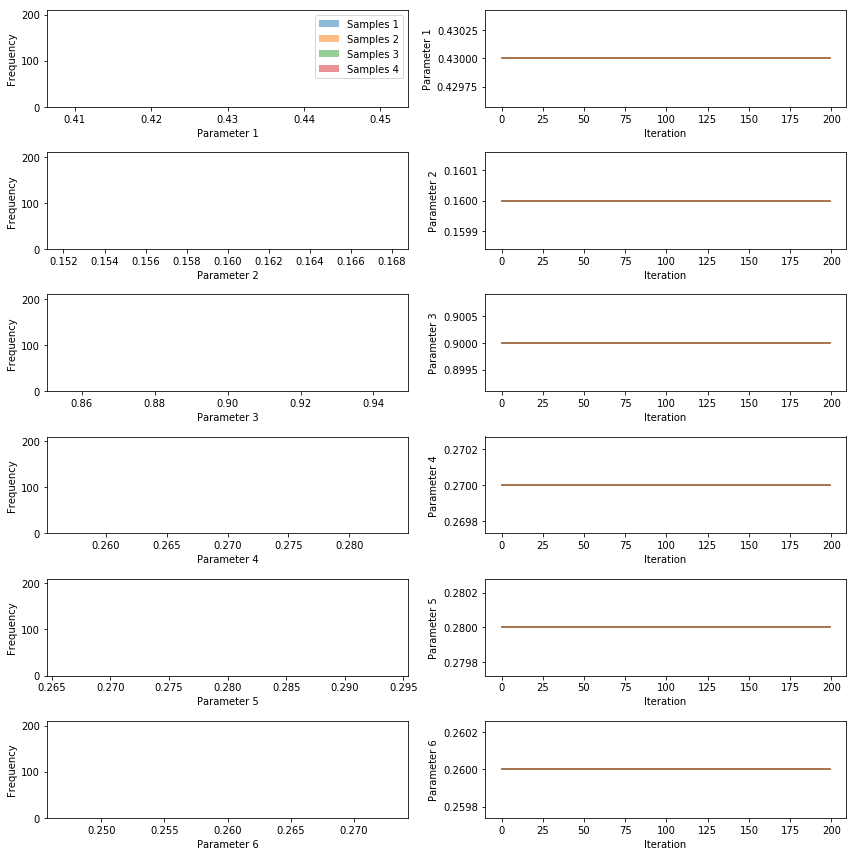

In [20]:
import pints.plot
pints.plot.trace(chains)
plt.show()

We get similar results as with adaptive covariance; except, the efficiency suffers due to having to calculate the sensitivities. Overall, for this problem, adaptive covariance performs favourably.

In [21]:
results = pints.MCMCSummary(chains=chains, parameter_names=["a", "b", "c", "d", "sigma_1", "sigma_2"], time=t)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
a        0.43    0.00    0.43    0.43   0.43   0.43   0.43     nan     nan    nan
b        0.16    0.00    0.16    0.16   0.16   0.16   0.16     0.99    3.96   0.46
c        0.90    0.00    0.90    0.90   0.90   0.90   0.90     0.99    3.96   0.46
d        0.27    0.00    0.27    0.27   0.27   0.27   0.27     nan     nan    nan
sigma_1  0.28    0.00    0.28    0.28   0.28   0.28   0.28     0.99    3.96   0.46
sigma_2  0.26    0.00    0.26    0.26   0.26   0.26   0.26     nan     3.96   0.46


/home/michael/dev/pints/pints/_diagnostics.py:112: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt((W + (1.0 / t) * (B - W)) / W)
/home/michael/dev/pints/pints/_diagnostics.py:16: RuntimeWarning: invalid value encountered in true_divide
  x = (x - np.mean(x)) / (np.std(x) * np.sqrt(len(x)))
